In [1]:
from picamera.array import PiYUVArray, PiRGBArray
from picamera import PiCamera

from scipy.signal import find_peaks, butter, filtfilt

import time
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np

# Camera resolution
res = (640, 480)

CAMERA_CENTER = res[0] // 2  # 320
       
from raceon import PWM

## Setup servo and motor PWM signal to control the steering angle and the speed.

The values specified period and duty cycle ar in nanoseconds.

Servo and motor controlled follow the following protocol:
  1. Control signal is read 50 times per second by each device (servo and speed controller). Thus period is 20 ms => 20000000 ns
  2. To send the minimum value (full left for servo and break for motor) the duty cycle should be 1 ms => 1000000 ns
  3. Maximum value corresponds to a duty cycle of 2 ms => 2000000 ns
  
However, these devices are not perfect and you can set a duty cycle outside this range and still get a response. I would recoment to play with it and find are the limits in your case. Pay attention that servo is limited by the mechanical construction how much it can turn the wheels. Do not set these limits to a value which servo cannot execute as it will try to do that and eventually burn.

In [2]:
# Enable servo
SERVO_MIDDLE = 1500000

servo = PWM(1)
servo.period = 20000000
servo.duty_cycle = SERVO_MIDDLE
servo.enable = True

In [3]:
# Enable servo
MOTOR_BRAKE = 1000000

motor = PWM(0)
motor.period = 20000000
motor.duty_cycle = MOTOR_BRAKE
motor.enable = True

In [4]:
motor.duty_cycle = MOTOR_BRAKE 

## The self driving code

Quick explanation on how this algorithm works:
  1. Initialize the camera, use a frame rate of 10 to 20 fps
  2. Get the coefficients of the butterworth filter of order 3 and cut-off frequency of 0.1 (change cut of frequency if the peak functions is not working)
  3. For each frame captured from the camera:
    1. Get the blak and white part of the image
    2. Select line 195 to use for lane detection (this number depends on your camera angle)
    3. Filter the line and find the peaks that are greater than 160. White parts of the image have higher values than the black. The threshold of 160 depends on the ambient light, lower if the room is darker
    4. Find the peaks left and right of the camera center, these peaks should corresponds to the white lines delimiting the track,
    5. Compute the center point between these lines. This is where we want our car
    6. Compute the error by substracting the center point from camera middle and multiply by 5000. 5000 is our P gain.
    7. Adjust the duty cycle of the servo such that the

In [ ]:
# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

RUN_TIMER = 35 # seconds
history=[]

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 10

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

# Measure the time needed to process 300 images to estimate the FPS
t = time.time()

# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.1)

line_pos    = CAMERA_CENTER
first_frame = True
current_time = None

# start car
car_speed = 300000
scan_line = 280
motor.duty_cycle = MOTOR_BRAKE + car_speed

try:
    for f in stream:
        turn = 0 # flag for turning
        last_time = current_time if current_time is not None else time.time()
        current_time = time.time()
        
        if first_frame:
            first_frame = False
            # Reset the buffer for the next image
            rawCapture.truncate(0)
            continue

        # Stop after RUN_TIMER seconds
        if (time.time() - t) > RUN_TIMER:
            break

        # Get the intensity component of the image (a trick to get black and white images)
        I = f.array[:, :, 0]

        # Reset the buffer for the next image
        rawCapture.truncate(0)

        # Select a horizontal line in the middle of the image
        L = I[scan_line, :]

        # Smooth the transitions so we can detect the peaks 
        Lf = filtfilt(b, a, L)
        history.append(Lf)

        # Find peaks which are higher than 0.5
        p = find_peaks(Lf, height=160)

        peaks = p[0]
        turn = 0

        line_left   = None
        line_right  = None
#         peaks_left  = peaks[peaks < CAMERA_CENTER]
#         peaks_right = peaks[peaks > CAMERA_CENTER]

        peaks_left  = peaks[peaks < line_pos]
        peaks_right = peaks[peaks > line_pos]

        if peaks_left.size:
            line_left = peaks_left.max()

        if peaks_right.size:
            line_right = peaks_right.min()
        if line_left and line_right:
            line_pos    = (line_left + line_right ) // 2
            track_width = line_right - line_left
        elif line_left and not line_right:
            line_pos    = line_left + int(track_width / 2)
            turn =1
        elif not line_left and line_right:
            line_pos    = line_right - int(track_width / 2)
            turn =1
        else:
            print("no line")

        print(line_pos, peaks)

            
        """
        PID controller
        output = Kp * error + Ki * integral_error + Kd * derivative_error
        """
        # DUTY_CYCLE = 5000 * (CAMERA_CENTER - line_pos) + SERVO_MIDDLE 
        Kp = 5000
        Ki = 300
        error = (CAMERA_CENTER - line_pos) 
        delta_time = current_time - last_time
        integral_error = error * delta_time

        DUTY_CYCLE = int(SERVO_MIDDLE + Kp * error + Ki * integral_error)
        
#         DUTY_CYCLE = SERVO_MIDDLE + 5000 * (CAMERA_CENTER - line_pos)
        if DUTY_CYCLE > 2000000:
            DUTY_CYCLE = 2000000
        if DUTY_CYCLE < 1000000:
            DUTY_CYCLE = 1000000

        if turn == 1:
            car_speed = 200000
        else:
            car_speed = 300000

        motor.duty_cycle = MOTOR_BRAKE + car_speed

        servo.duty_cycle =  DUTY_CYCLE
        
        last_time = current_time
        
        print(DUTY_CYCLE)

    #Initialize lines position
    #Check which lines are closer them in the next frame

    #print(line_pos)
except Exception as e:
    print('except!', e)
    motor.duty_cycle = MOTOR_BRAKE    

    # Release resources
    stream.close()
    rawCapture.close()
    camera.close()

motor.duty_cycle = MOTOR_BRAKE    

# Release resources
stream.close()
rawCapture.close()
camera.close()

290 [ 32 548]
1650592
290 [ 31 550 597]
1650507
290 [ 30 551 597]
1650593
292 [ 27 558 608]
1640413
293 [ 31 556 592]
1635419
300 [ 39 561 598]
1600306
302 [ 42 562 598]
1590259
308 [ 54 563 599]
1560181
313 [ 57 570 605]
1535097
321 [ 60 583 618]
1494985
325 [ 65 585 619]
1474925
320 [ 58 583 616]
1500000
319 [ 60 579 613]
1505015
316 [ 54 578 612]
1520059
319 [ 58 581 617]
1505014
307 [ 43 572 607]
1565195
306 [ 44 569 605]
1570208
300 [ 39 562 602]
1600302
301 [ 37 565 608]
1595418
304 [ 44 565 608]
1580344
305 [ 45 566 608]
1575255
311 [ 49 573 613]
1545135
314 [ 55 574 613]
1530089
311 [ 52 571 608]
1545129
319 [ 61 577 613]
1505014
319 [ 58 580 616]
1505015
321 [ 58 585 616]
1494985
320 [15 57]
1500000
330 [19 67]
1449834
358 [85 95]
1309217
395 [115 132]
1123606
456 [174 193]
1000000
494 [202 231]
1000000
542 [243 265 279]
1000000
591 [290 310 328]
1000000
650 [352 369 387]
1000000
688 [397 412 425]
1000000
715 [423 452]
1000000
731 [440 468]
1000000
740 [453 477]
1000000
745 [4

In [8]:
# Release resources
stream.close()
rawCapture.close()
camera.close()
motor.duty_cycle = MOTOR_BRAKE   

[491 548]


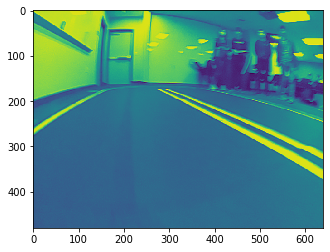

In [27]:
plt.imshow(I)
print(peaks)

In [ ]:

peaks = p[0]

line_left   = None
line_right  = None
peaks_left  = peaks[peaks < CAMERA_CENTER]
peaks_right = peaks[peaks > CAMERA_CENTER]

if peaks_left.size:
    line_left = peaks_left.max()
    
if peaks_right.size:
    line_right = peaks_right.min()
    
p

In [ ]:
L = I[200, :]
b, a = butter(3, 0.1)
Lf = filtfilt(b, a, L)

plt.plot(L)
plt.plot(Lf)

In [ ]:
plt.imshow(np.vstack(history))